In [1]:
!pip install transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import getpass
import os
os.environ["HUGGINGFACE_API_KEY"] = getpass.getpass()

··········


In [85]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

import pandas as pd
# read data and put it in a dataframe
# 在 google 工作表載入 gsheets
gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1ia1VzdZqT7I_HAe9I_To0tNd87ywK1LVtEhS8-iQOQg/edit#gid=0')
# 從 gsheets 的工作表
sheets1 = gsheets.worksheet('test').get_all_values()

df = pd.DataFrame(sheets1[1:], columns=sheets1[0])

In [86]:
df.head()

,model,quantity,Already ordered,option,cabin code,cabin configuration,serial number,Remark,refer to,C,K,Y,total
0,空中巴士A350-1041XWB國際知名航空專業評鑑網站AirlineRatings.com...,—,18,6,-351,TBA,TBA,預計2026年交機，另有6架選擇權，取代較舊的波音777-300ER（出廠年份：2006～2...,,C,K,Y,
1,波音777-35E/36N/3AL/3SH(ER)國際知名航空專業評鑑網站AirlineRa...,13,—,—,77M,38,64,221,323,B-16703～,C,K,Y
2,波音777-35E/36N/3AL/3SH(ER)國際知名航空專業評鑑網站AirlineRa...,11,77A,39,56,238,333,B-16718～,,,,,
3,波音777-35E/36N/3AL/3SH(ER)國際知名航空專業評鑑網站AirlineRa...,10,77B,39,56,258,353,B-16730～,,,,,
4,波音777-35E/36N/3AL/3SH(ER)國際知名航空專業評鑑網站AirlineRa...,—,—,—,—,—,—,B-16740～,,,,,


In [87]:
import re
# 只保留中文字
def keep_chinese_chars(text):
    pattern = re.compile(r'[^\u4e00-\u9fff]')
    chinese_text = re.sub(pattern, '', text)
    chinese_text = chinese_text.replace("推推", "")
    return chinese_text

In [88]:
text = df['model'][0]
text = keep_chinese_chars(text)
text

'空中巴士國際知名航空專業評鑑網站於昨日公布最佳航空公司大獎的評選結果長榮航空榮獲年全球二十五大最佳航空公司第名之殊榮並獲得七顆星的評價也是台灣唯一入榜的航空公司總編輯傑佛瑞湯瑪士表示我們看重航空公司在改善旅客搭機體驗上的領導力和創新力然而現在航空產業面臨前所未有的壓力從疫情復甦到烏俄戰爭都對全球旅客造成極大的影響長榮航空總經理孫嘉明表示很高興長榮航空全體同仁的努力受到全球旅客的肯定在疫情期間我們不斷精進各項服務包括推出提供數位化報刊雜誌推行自動報到等服務在各國疫情解封後有序地恢復航班和機上服務並持續與米其林餐廳主廚冠軍咖啡師合作讓機上的餐飲更加豐富多元化並同時擴及到更多的航線'

In [89]:
from transformers import AutoModelForCausalLM, AutoTokenizer

def Mistral_summarize(text):

  device = "cuda" # the device to load the model onto

  model = AutoModelForCausalLM.from_pretrained("MediaTek-Research/Breeze-7B-Instruct-v1_0")
  tokenizer = AutoTokenizer.from_pretrained("MediaTek-Research/Breeze-7B-Instruct-v1_0")

  messages = [
      {"role": "user", "content": "What is your favourite condiment?"},
      {"role": "assistant", "content": "Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!"},
      {"role": "user", "content": {text}}
  ]

  encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

  model_inputs = encodeds.to(device)

  generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True)
  decoded = tokenizer.batch_decode(generated_ids)

  return decoded

In [90]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import torch

def bart_summarize(text):

    keep_chinese_chars(text)

    tokenizer = BertTokenizer.from_pretrained('hfl/chinese-bert-wwm')
    model = BertForMaskedLM.from_pretrained('hfl/chinese-bert-wwm')

    inputs = tokenizer(text, return_tensors="pt", max_length=100, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=128)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [91]:
summary = bart_summarize(text)
print(summary)

Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


空 中 巴 士 國 際 知 名 航 空 專 業 評 鑑 網 站 於 昨 日 公 布 最 佳 航 空 公 司 大 獎 的 評 選 結 果 長 榮 航 空 榮 獲 年 全 球 二 十 五 大 最 佳 航 空 公 司 第 名 之 殊 榮 並 獲 得 七 顆 星 的 評 價 也 是 台 灣 唯 一 入 榜 的 航 空 公 司 總 編 輯 傑 佛 瑞 湯 瑪 士 表 示 我 們 看 重 航 空 公 司 公 司 的 表 現 ， 「 最 為 看 重 的 是 它 們 的 人 」 ， 而 「 在 我 看 來 ， 它


In [92]:
def remove_spaces(text):
    # 使用 replace 方法來刪除空格
    return text.replace(" ", "")

output_text = remove_spaces(summary)
output_text

'空中巴士國際知名航空專業評鑑網站於昨日公布最佳航空公司大獎的評選結果長榮航空榮獲年全球二十五大最佳航空公司第名之殊榮並獲得七顆星的評價也是台灣唯一入榜的航空公司總編輯傑佛瑞湯瑪士表示我們看重航空公司公司的表現，「最為看重的是它們的人」，而「在我看來，它'

In [93]:
import jieba
import jieba.analyse

jieba.analyse.extract_tags(output_text, topK=10)

['航空公司', '看重', '最佳', '航空', '空中巴士', '國際', '專業', '評鑑', '網站', '大獎']

In [94]:
# 使用 jieba 提取關鍵字
def extract_keywords(text):
    #text = keep_chinese_chars(text)

    summary = bart_summarize(text)
    outputt_ext = remove_spaces(summary)

    return jieba.analyse.extract_tags(outputt_ext, topK=10)  # 提取前十個關鍵字

df['keywords'] = df['model'].apply(extract_keywords)

Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a m

In [96]:
df.head()

,model,quantity,Already ordered,option,cabin code,cabin configuration,serial number,Remark,refer to,C,K,Y,total,keywords
0,空中巴士A350-1041XWB國際知名航空專業評鑑網站AirlineRatings.com...,—,18,6,-351,TBA,TBA,預計2026年交機，另有6架選擇權，取代較舊的波音777-300ER（出廠年份：2006～2...,,C,K,Y,,"[2019, 2018, 航空公司, 最佳, 航空, 空中巴士, a350, 1041xwb..."
1,波音777-35E/36N/3AL/3SH(ER)國際知名航空專業評鑑網站AirlineRa...,13,—,—,77M,38,64,221,323,B-16703～,C,K,Y,"[travel, 航空公司, 最佳, 航空, 777, 35e, 36n, 3al, 3sh..."
2,波音777-35E/36N/3AL/3SH(ER)國際知名航空專業評鑑網站AirlineRa...,11,77A,39,56,238,333,B-16718～,,,,,,"[travel, 航空公司, 最佳, 航空, 777, 35e, 36n, 3al, 3sh..."
3,波音777-35E/36N/3AL/3SH(ER)國際知名航空專業評鑑網站AirlineRa...,10,77B,39,56,258,353,B-16730～,,,,,,"[travel, 航空公司, 最佳, 航空, 777, 35e, 36n, 3al, 3sh..."
4,波音777-35E/36N/3AL/3SH(ER)國際知名航空專業評鑑網站AirlineRa...,—,—,—,—,—,—,B-16740～,,,,,,"[travel, 航空公司, 最佳, 航空, 777, 35e, 36n, 3al, 3sh..."


In [97]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from community import community_louvain

In [98]:
G = nx.Graph()

for index, row in df.iterrows():
    Remark = row['Remark']
    keywords = row['keywords']

    G.add_node(Remark, type='Remark')

    for keyword in keywords:
        G.add_node(keyword, type='Remark')
        G.add_edge(Remark, keyword)

In [99]:
keywords

['航空公司', '最佳', '航空', '空中巴士', 'a330', '203', '國際', '專業', '評鑑', '網站']

In [100]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
from matplotlib.font_manager import fontManager
# 改style要在改font之前
# plt.style.use('seaborn')
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2024-04-25 11:01:19--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.202.101, 74.125.202.138, 74.125.202.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.202.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-04-25 11:01:19--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.148.132, 2607:f8b0:4001:c54::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.148.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  83.0MB/s    in 0.2s    

2024-04-25 11:0

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


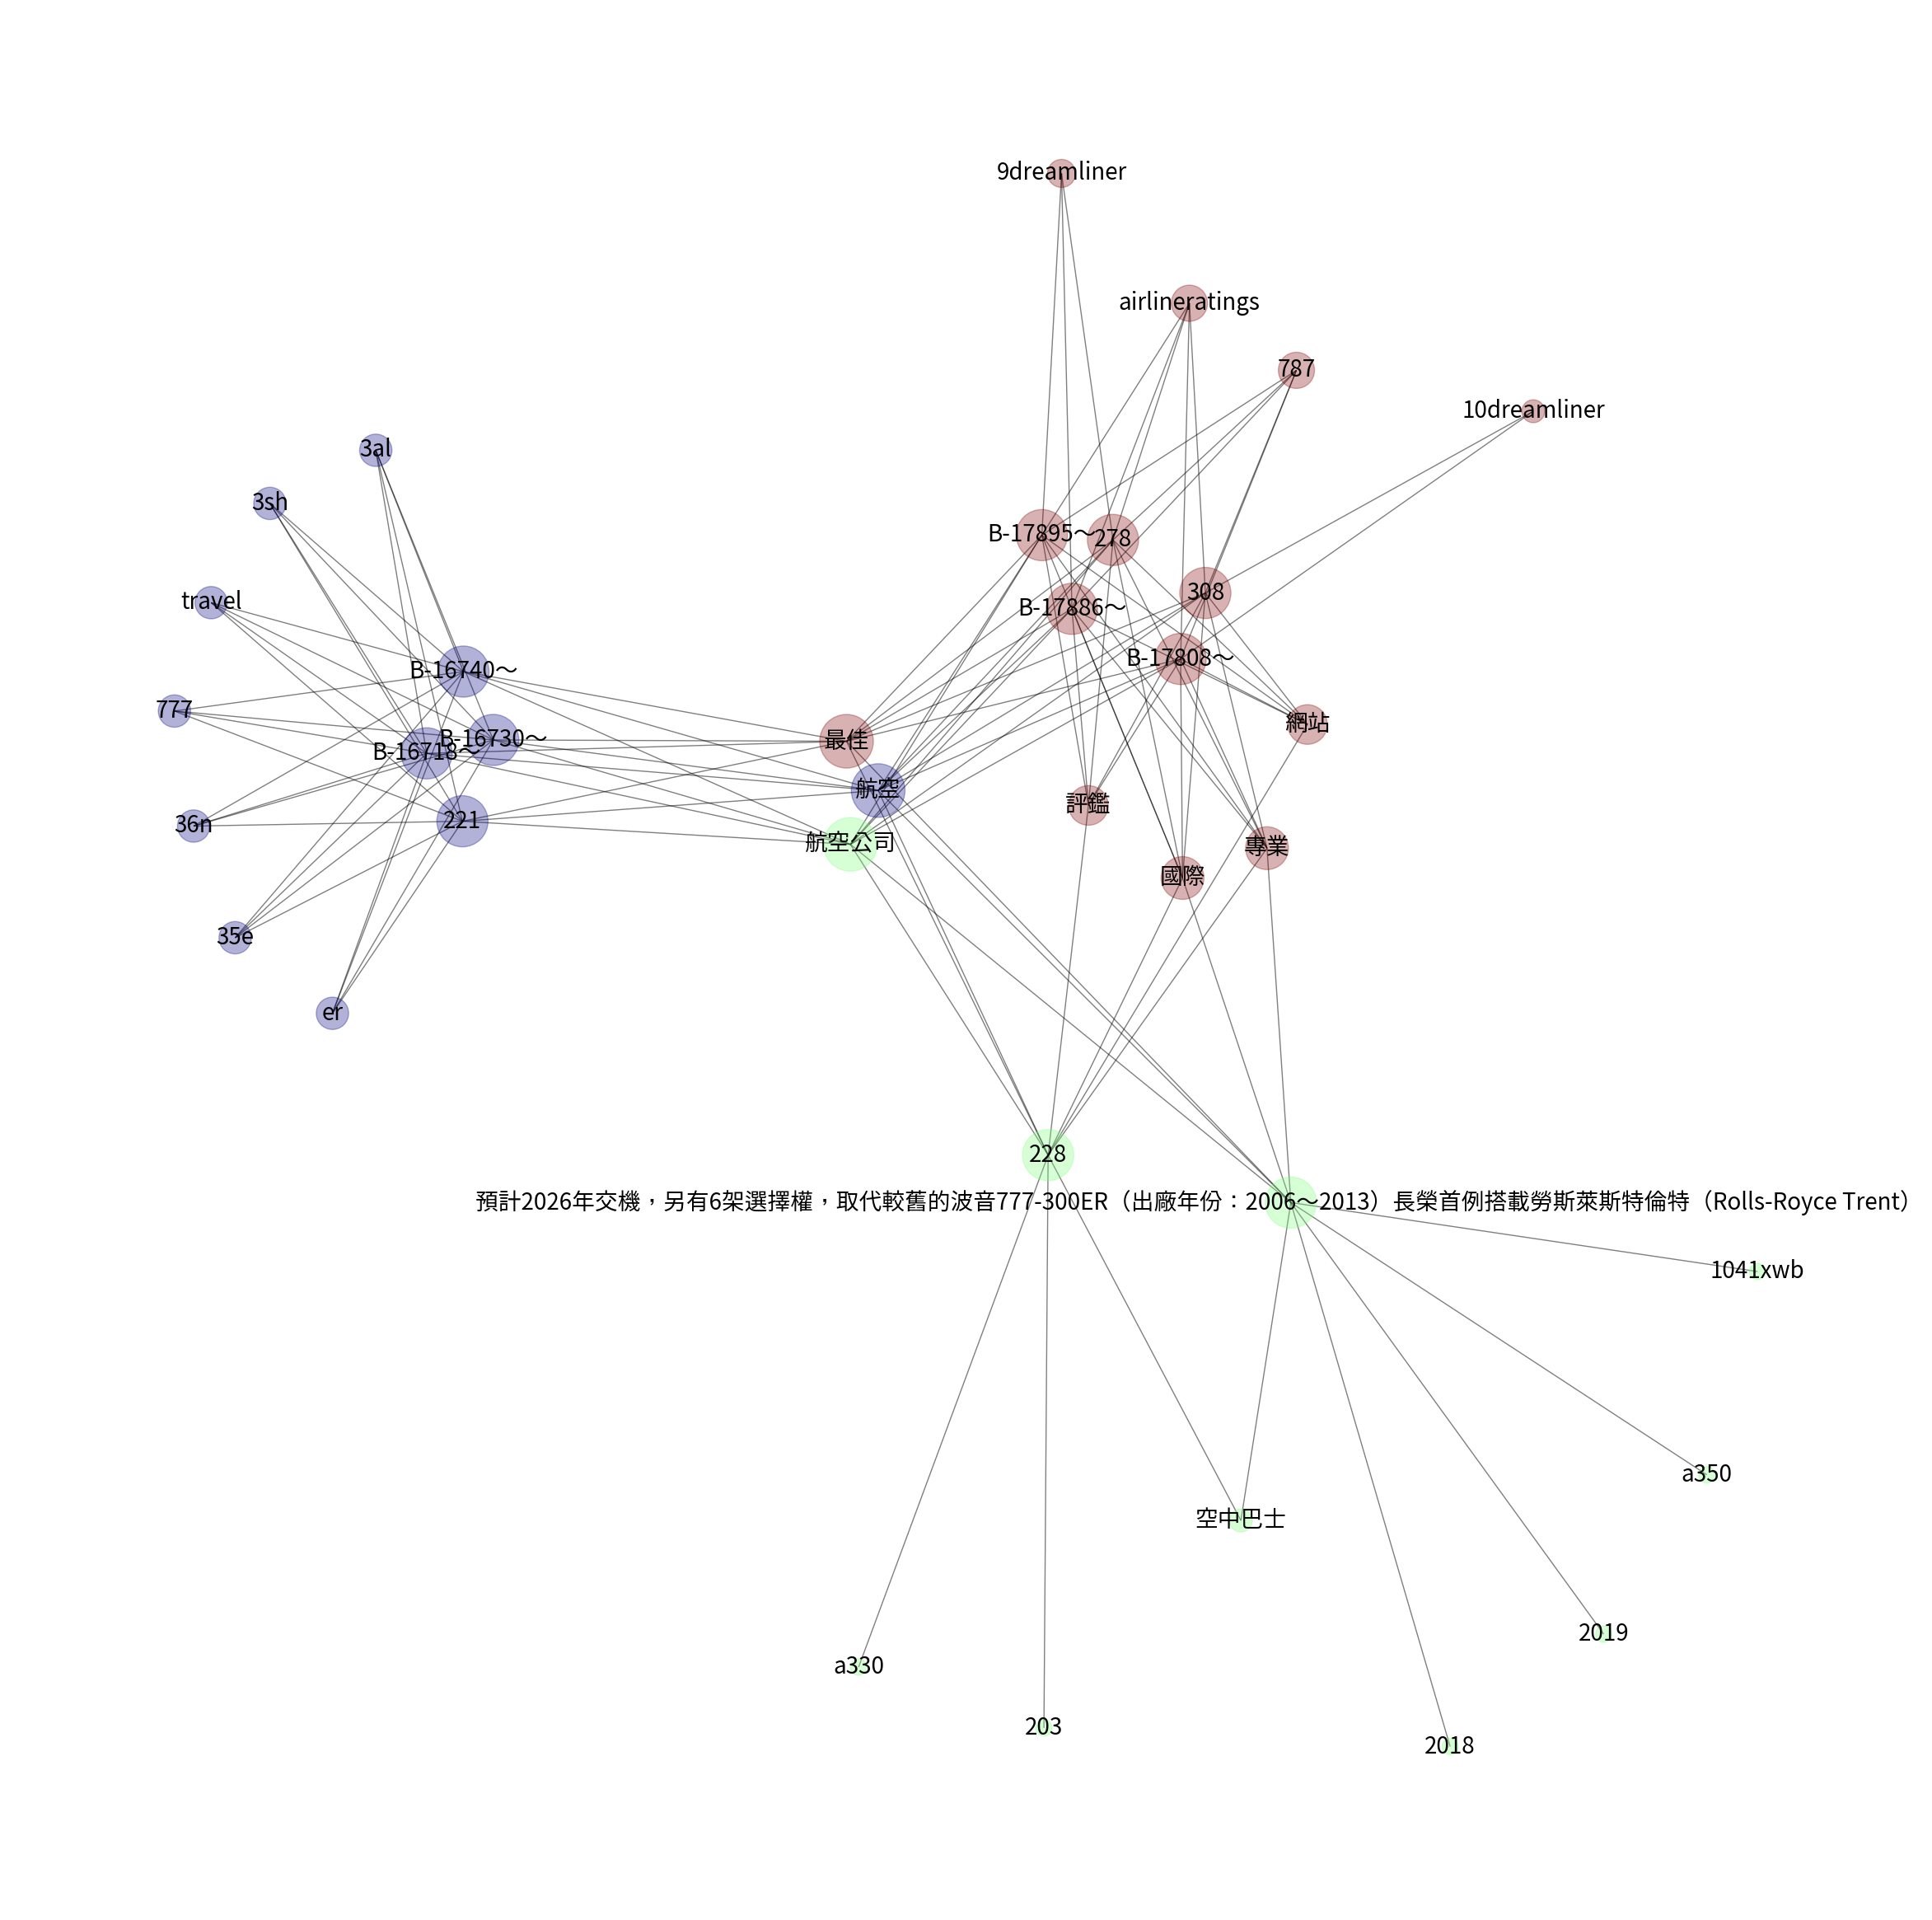

In [101]:
partition = community_louvain.best_partition(G)

community_colors = [partition[node] for node in G.nodes()]

cmap = plt.cm.jet
colors_with_alpha = [cmap(community_color / max(community_colors)) for community_color in community_colors]

colors_with_alpha = [(r, g, b, 0.3) for r, g, b, _ in colors_with_alpha]

node_sizes = [200 * G.degree(node) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.2, iterations=80)

plt.figure(figsize=(30, 30))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color=colors_with_alpha, node_size=node_sizes, cmap=plt.cm.jet)
nx.draw_networkx_labels(G, pos, font_size=20, font_family='Taipei Sans TC Beta')

plt.axis('off')
plt.show()